# 🔥 1D Heat Equation with Boundary and Initial Conditions

We consider the one-dimensional heat equation:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}, \quad x \in [0, 1], \quad t > 0
$$

## Initial Condition:
$$
u(x, 0) = \sin(\pi x)
$$

## Boundary Conditions:
$$
u(0, t) = 0, \quad u(1, t) = 0 \quad \text{for all } t \geq 0
$$

---

# ✅ Exact Solution:
The analytical solution to this problem is:

$$
u(x, t) = \sin(\pi x) \cdot e^{-\pi^2 t}
$$

This solution:
- Satisfies the heat equation
- Fulfills the boundary conditions $u(0,t) = u(1,t) = 0$
- Matches the initial condition $u(x,0) = \sin(\pi x)$

---

# 📌 Notes:
- The solution describes how heat diffuses along a 1D rod of length 1 with ends kept at zero temperature.
- The temperature decays exponentially over time due to the $e^{-\pi^2 t}$ factor.


In [1]:
# Heat Equation PINN
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

In [2]:
# Set random seed for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

In [3]:
# Set default dtype and device
torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# #1 Initialize PINN Model

In [4]:
class PINN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=1, num_layers=6):
        super(PINN, self).__init__()

        # Input layer with Fourier feature encoding
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))

        # Output layer
        self.output_layer = nn.Linear(hidden_dim, output_dim)

        # Sinusoidal activation for better handling of periodic functions
        self.activation = nn.Tanh()

        # Initialize weights using Xavier initialization
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, t):
        # Concatenate inputs
        inputs = torch.cat([x, t], dim=1)

        # Initial layer
        z = self.activation(self.input_layer(inputs))

        # Hidden layers with residual connections
        for i, layer in enumerate(self.hidden_layers):
            z_prev = z
            z = self.activation(layer(z))
            # Add residual connection every two layers
            if i % 2 == 1:
                z = z + z_prev

        # Output layer
        output = self.output_layer(z)

        # Apply boundary conditions directly using soft constraints
        # This helps enforce u(0,t) = 0 and u(1,t) = 0
        output = output * x * (1 - x)

        return output

In [7]:
model = PINN()
model

PINN(
  (input_layer): Linear(in_features=2, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-5): 6 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (activation): Tanh()
)

# #2 Heat PDE and other conditions

In [8]:
# PDE residual function for 1D Heat Equation: u_t = u_xx
def heat_pde(u, x, t):
    # Compute gradients with better numerical stability
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    return u_t - u_xx

# Initial and boundary conditions
def initial_condition(x):
    return torch.sin(np.pi * x)

def boundary_condition_left(t):
    return torch.zeros_like(t)  # u(0, t) = 0

def boundary_condition_right(t):
    return torch.zeros_like(t)  # u(1, t) = 0

# Analytical solution for validation
def analytical_solution(x, t):
    return torch.sin(np.pi * x) * torch.exp(-np.pi**2 * t)

# #3 Generate Training Data

In [9]:
def generate_training_data():
    """Generate training data with improved sampling"""
    # Training data parameters with increased domain points for better representation
    N_f = 50000   # Interior points (PDE residual)
    N_u = 500     # Initial condition points
    N_b = 500     # Boundary condition points

    # Use Latin Hypercube Sampling for better space coverage
    sampler = qmc.LatinHypercube(d=2, seed=1234)
    lhs_samples = sampler.random(n=N_f)

    # Keep both x and t in [0, 1]
    x_f = lhs_samples[:, [0]]
    t_f = lhs_samples[:, [1]]

    # Convert to torch tensors
    x_f = torch.tensor(x_f, dtype=torch.float32, device=device)
    t_f = torch.tensor(t_f, dtype=torch.float32, device=device)
    x_f.requires_grad = True
    t_f.requires_grad = True

    # Initial condition points: x in [0, 1], t = 0
    x_u = torch.linspace(0, 1, N_u, device=device).unsqueeze(1)
    t_u = torch.zeros_like(x_u)
    u_u = initial_condition(x_u)
    x_u.requires_grad = True
    t_u.requires_grad = True

    # Boundary condition points: x = 0 and x = 1, t in [0, 1]
    t_b = torch.linspace(0, 1, N_b, device=device).unsqueeze(1)
    x_b1 = torch.zeros_like(t_b)
    x_b2 = torch.ones_like(t_b)
    u_b1 = boundary_condition_left(t_b)
    u_b2 = boundary_condition_right(t_b)
    x_b1.requires_grad = True
    x_b2.requires_grad = True
    t_b.requires_grad = True

    print("Data shapes:")
    print(f"PDE points: {x_f.shape}")
    print(f"Initial condition: {x_u.shape}")
    print(f"Boundary conditions: {x_b1.shape}, {x_b2.shape}")

    return x_f, t_f, x_u, t_u, u_u, x_b1, x_b2, t_b, u_b1, u_b2

In [15]:
# Generate training data
training_data = generate_training_data()

Data shapes:
PDE points: torch.Size([50000, 1])
Initial condition: torch.Size([500, 1])
Boundary conditions: torch.Size([500, 1]), torch.Size([500, 1])


# #4 Traing Model

In [10]:
def train_model(model, training_data, epochs=20000):
    """Train the PINN model with adaptive weighting and early stopping"""
    x_f, t_f, x_u, t_u, u_u, x_b1, x_b2, t_b, u_b1, u_b2 = training_data

    # Optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, verbose=True, min_lr=1e-5)
    # Loss tracking
    loss_history = []
    loss_ic_history = []
    loss_bc_history = []
    loss_pde_history = []

    # Early stopping parameters
    best_loss = float('inf')
    patience = 1000
    patience_counter = 0

    # Initial weights for different loss components
    w_ic = 100.0  # Higher weight on initial condition
    w_bc = 100.0  # Higher weight on boundary conditions
    w_pde = 1.0   # Lower weight on PDE residual initially

    for epoch in range(epochs):
        optimizer.zero_grad()
        # Forward pass
        u_pred_u = model(x_u, t_u)
        u_pred_b1 = model(x_b1, t_b)
        u_pred_b2 = model(x_b2, t_b)
        u_pred_f = model(x_f, t_f)

        # Compute PDE residual
        f_pred = heat_pde(u_pred_f, x_f, t_f)

        # Individual loss components
        loss_ic = torch.mean((u_pred_u - u_u)**2)
        loss_bc = torch.mean((u_pred_b1 - u_b1)**2) + torch.mean((u_pred_b2 - u_b2)**2)
        loss_pde = torch.mean(f_pred**2)

        # Adaptive weighting strategy
        # Gradually increase PDE weight and decrease BC/IC weights
        if epoch > 5000:
            w_pde = min(10.0, w_pde * 1.0005)  # Gradually increase PDE weight
            w_ic = max(10.0, w_ic * 0.9999)    # Gradually decrease IC weight
            w_bc = max(10.0, w_bc * 0.9999)    # Gradually decrease BC weight

        # Combined loss with weighted components
        loss = w_ic * loss_ic + w_bc * loss_bc + w_pde * loss_pde
        # Backpropagation
        loss.backward()
        optimizer.step()
        # Update learning rate scheduler
        scheduler.step(loss)
        # Log losses
        loss_history.append(loss.item())
        loss_ic_history.append(loss_ic.item())
        loss_bc_history.append(loss_bc.item())
        loss_pde_history.append(loss_pde.item())

        # Early stopping logic
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
            # Save best model
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter > patience:
                print(f"Early stopping at epoch {epoch}")
                model.load_state_dict(best_model_state)  # Restore best model
                break

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.8f}, IC: {loss_ic.item():.8f}, BC: {loss_bc.item():.8f}, PDE: {loss_pde.item():.8f}")

    return model, (loss_history, loss_ic_history, loss_bc_history, loss_pde_history)

In [14]:
# Initialize model
model = PINN(input_dim=2, hidden_dim=64, output_dim=1, num_layers=6).to(device)
print(model)

PINN(
  (input_layer): Linear(in_features=2, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-5): 6 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (activation): Tanh()
)


In [16]:
# Train model
model, loss_data = train_model(model, training_data)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 64.67052460, IC: 0.61080652, BC: 0.00000000, PDE: 3.58986855
Epoch 1000, Loss: 0.00209246, IC: 0.00001015, BC: 0.00000000, PDE: 0.00107795
Epoch 2000, Loss: 0.13660111, IC: 0.00122300, BC: 0.00000000, PDE: 0.01430138
Epoch 3000, Loss: 0.00020116, IC: 0.00000003, BC: 0.00000000, PDE: 0.00019773
Epoch 4000, Loss: 0.00013488, IC: 0.00000005, BC: 0.00000000, PDE: 0.00013011
Epoch 5000, Loss: 0.00009229, IC: 0.00000004, BC: 0.00000000, PDE: 0.00008870
Epoch 6000, Loss: 0.00013384, IC: 0.00000010, BC: 0.00000000, PDE: 0.00007594
Epoch 7000, Loss: 0.00007132, IC: 0.00000003, BC: 0.00000000, PDE: 0.00002532
Epoch 8000, Loss: 0.00005663, IC: 0.00000002, BC: 0.00000000, PDE: 0.00001234
Epoch 9000, Loss: 0.00005080, IC: 0.00000001, BC: 0.00000000, PDE: 0.00000676
Early stopping at epoch 9588


# #4 Evaluating Model

In [17]:
def evaluate_model(model):
    """Evaluate the trained model against analytical solution"""
    # Define test data for visualization
    x_test = torch.linspace(0, 1, 100, device=device).unsqueeze(1)
    t_test = torch.linspace(0, 1, 100, device=device).unsqueeze(1)
    X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze())
    X_flat = X.reshape(-1, 1)
    T_flat = T.reshape(-1, 1)

    # Predicted and analytical solutions
    with torch.no_grad():
        u_pred = model(X_flat, T_flat).reshape(X.shape).cpu().numpy()
        u_exact = analytical_solution(X_flat, T_flat).reshape(X.shape).cpu().numpy()

    # Error computation
    error = np.abs(u_pred - u_exact)
    max_error = np.max(error)
    mse = np.mean((u_pred - u_exact)**2)
    rel_l2_error = np.sqrt(np.sum((u_pred - u_exact)**2) / np.sum(u_exact**2))

    print(f"Maximum absolute error: {max_error:.6f}")
    print(f"Mean squared error: {mse:.6f}")
    print(f"Relative L2 error: {rel_l2_error:.6f}")

    return X.cpu().numpy(), T.cpu().numpy(), u_pred, u_exact, error

In [18]:
# Evaluate model
X, T, u_pred, u_exact, error = evaluate_model(model)

Maximum absolute error: 0.000159
Mean squared error: 0.000000
Relative L2 error: 0.000227


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# #6 Plot Loss History

In [19]:
def plot_loss_history(loss_history, loss_ic_history, loss_bc_history, loss_pde_history):
    """Generate visualization plots for the loss history"""
    # Plot loss history
    plt.figure(figsize=(12, 8))
    plt.semilogy(loss_history, 'b-', label='Total Loss')
    plt.semilogy(loss_ic_history, 'r-', label='Initial Condition Loss')
    plt.semilogy(loss_bc_history, 'g-', label='Boundary Condition Loss')
    plt.semilogy(loss_pde_history, 'm-', label='PDE Residual Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.grid(True)
    plt.title('Training Loss History')
    plt.savefig('loss_history.png', dpi=300, bbox_inches='tight')
    plt.show()

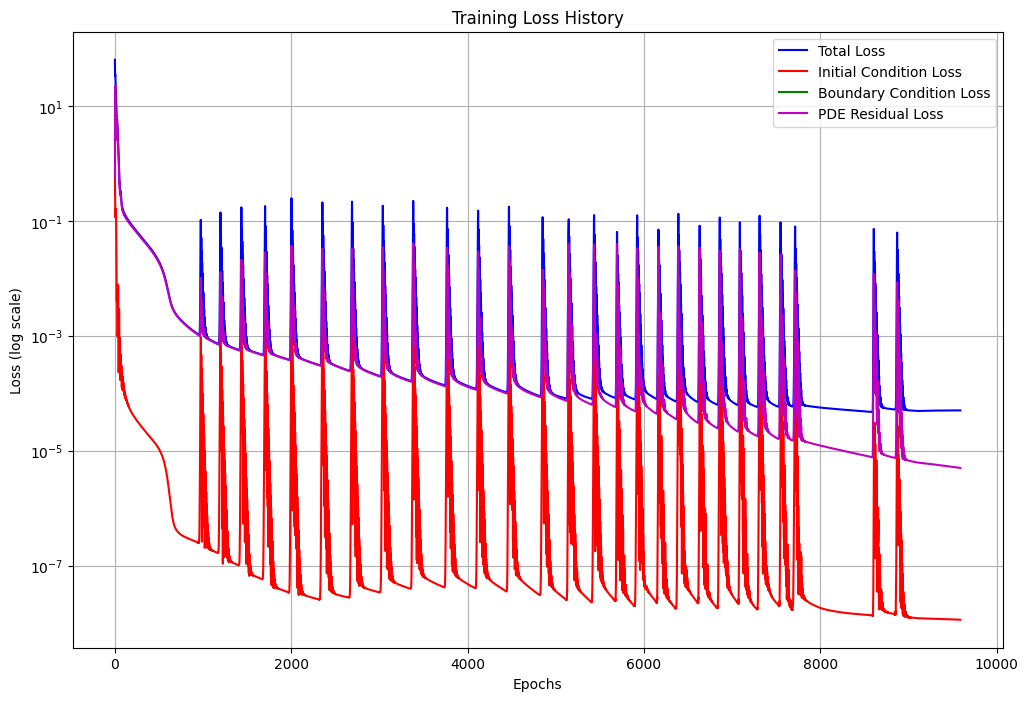

In [20]:
# Plot results
plot_loss_history(*loss_data)

# #7 Plot Results

In [21]:
def plot_results(X, T, u_pred, u_exact, error):
    """Generate visualization plots for the results"""
    # Plot 3D surface comparison
    max_error = np.max(error)
    fig = plt.figure(figsize=(18, 10))

    # Plot prediction
    ax = fig.add_subplot(221, projection='3d')
    surf = ax.plot_surface(X, T, u_pred, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    ax.set_title('PINN Prediction')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    # Plot exact solution
    ax = fig.add_subplot(222, projection='3d')
    surf = ax.plot_surface(X, T, u_exact, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    ax.set_title('Exact Solution')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    # Plot error
    ax = fig.add_subplot(223, projection='3d')
    surf = ax.plot_surface(X, T, error, cmap='hot')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('Error')
    ax.set_title(f'Absolute Error (Max: {max_error:.6f})')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    # Plot cross-sections at different time points
    ax = fig.add_subplot(224)
    x_test = np.linspace(0, 1, 100)
    t_indices = [0, 24, 49, 74, 99]  # Different time points
    t_values = np.linspace(0, 1, 100)
    for i in t_indices:
        ax.plot(x_test, u_pred[:, i], '-', label=f't={t_values[i]:.2f} (PINN)')
        ax.plot(x_test, u_exact[:, i], '--', label=f't={t_values[i]:.2f} (Exact)')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_title('Solution Comparison at Different Times')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True)

    plt.tight_layout()
    plt.savefig('solution_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot prediction vs exact solution at multiple time points
    plt.figure(figsize=(14, 10))

    # Select specific time points
    t_points = [0.1, 0.3, 0.5, 0.7, 0.9]
    colors = ['b', 'g', 'r', 'c', 'm']
    t_values = np.linspace(0, 1, 100)

    for i, t_val in enumerate(t_points):
        # Find closest index to desired time value
        t_idx = np.argmin(np.abs(t_values - t_val))

        plt.subplot(len(t_points), 1, i+1)
        plt.plot(x_test, u_pred[:, t_idx], f'{colors[i]}-', linewidth=2, label=f'PINN (t={t_val:.1f})')
        plt.plot(x_test, u_exact[:, t_idx], f'{colors[i]}--', linewidth=2, label=f'Exact (t={t_val:.1f})')
        plt.xlabel('x')
        plt.ylabel('u(x,t)')
        plt.title(f'Solution at t = {t_val:.1f}')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.savefig('time_slices.png', dpi=300, bbox_inches='tight')
    plt.show()

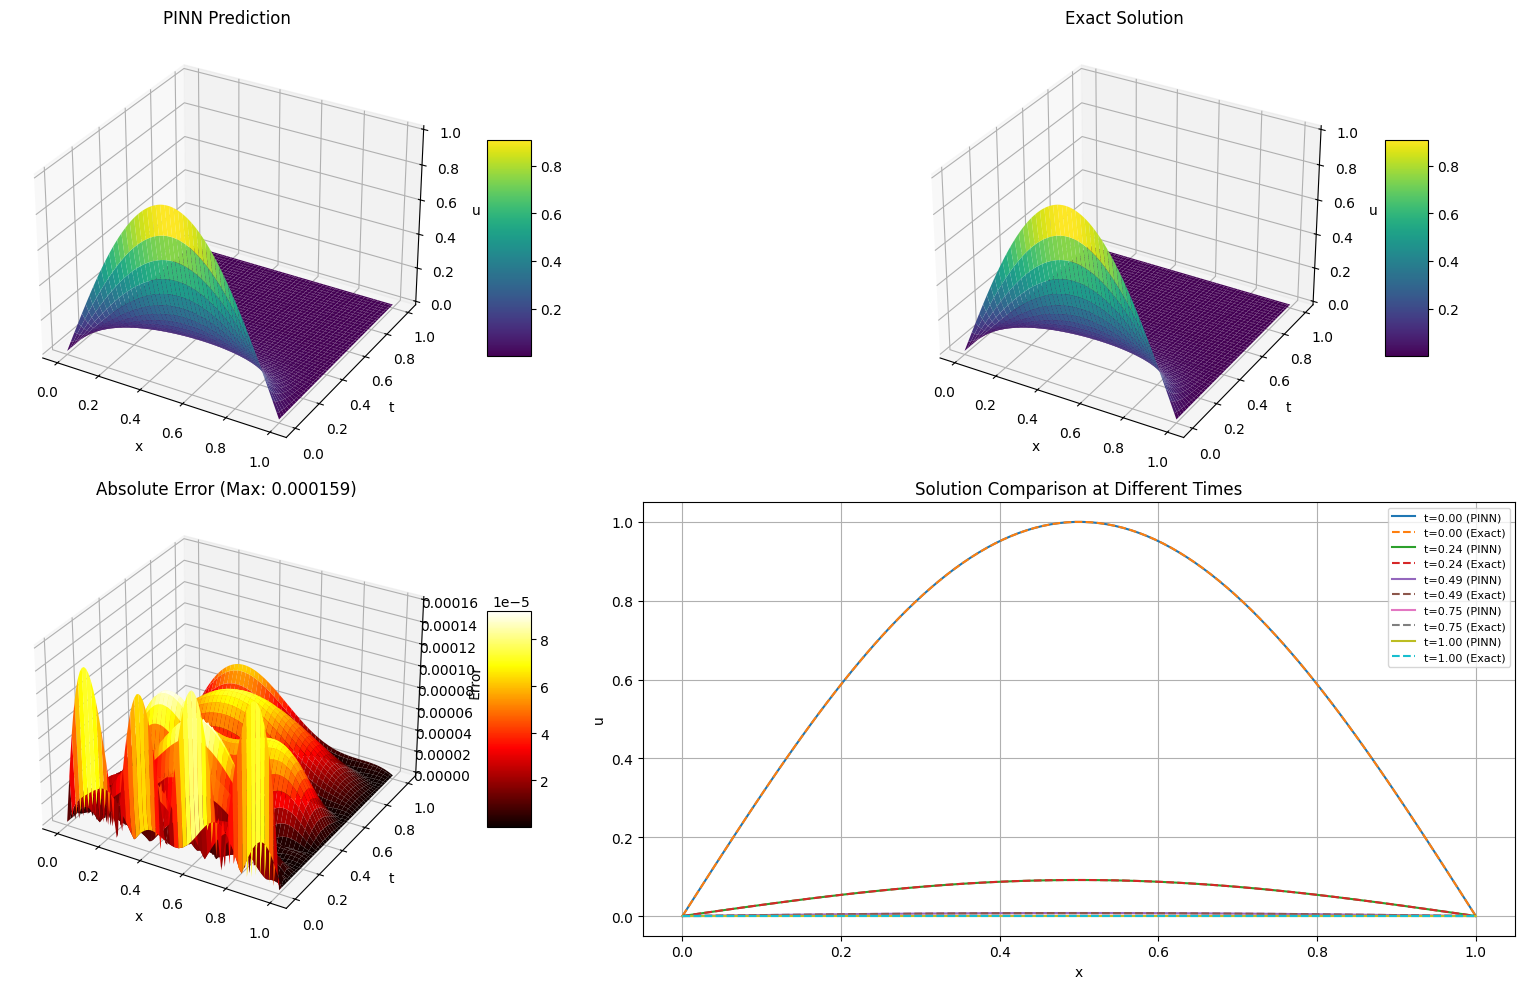

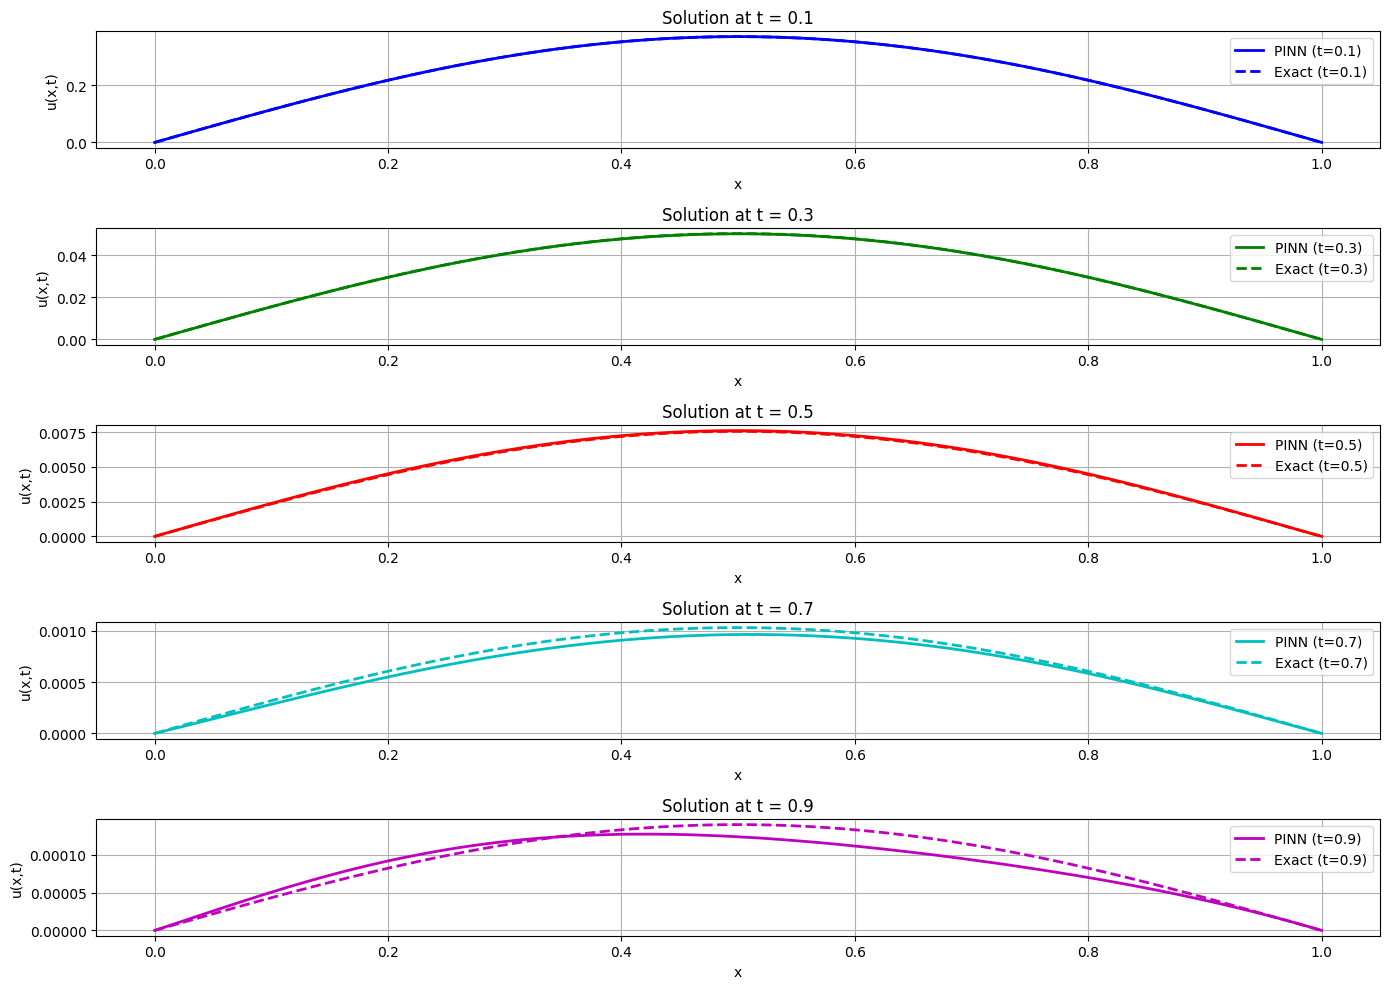

In [22]:
# Plot results
plot_results(X, T, u_pred, u_exact, error)

# #8 Saving Model

In [23]:
# Save model
torch.save(model.state_dict(), 'heat_equation_pinn_model.pt')
print("Model saved successfully.")

Model saved successfully.
